# Module 7: RNA-seq Analysis - From Raw Counts to Differential Expression


## 1. Introduction and Data Setup

In this module, we'll analyze RNA-seq data from SARS-CoV-2 infected cells.
The data comes from a 2020 Cell paper that examined transcriptional responses to SARS-CoV-2.
We'll build our analysis step by step, demonstrating why sophisticated tools like DESeq2
are necessary for accurate differential expression analysis.

Our goals:
1. Understand the challenges of RNA-seq data analysis
2. Learn how to properly normalize and analyze count data
3. Discover genes affected by SARS-CoV-2 infection
4. Apply data science skills to draw biological conclusions



In [1]:
# Load required libraries
library(tximport)      # For importing Salmon quantification files
library(DESeq2)        # For differential expression analysis
library(tidyverse)     # For data manipulation and visualization
library(rtracklayer)   # For importing GTF files
library(rstatix)       # For simple statistical tests
library(ggplot2)       # For plotting
library(patchwork)     # For combining plots
library(pheatmap)      # For heatmaps
library(EnhancedVolcano) # For better volcano plots

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

In [2]:
# Import GTF for gene annotations
gtf <- import("assets/genome/gencode.v47.basic.annotation.gtf.gz")

In [3]:
# Create tx2gene mapping WITHOUT stripping version numbers
# This maintains compatibility with Salmon outputs
tx2gene <- data.frame(
    TXNAME = gtf$transcript_id[gtf$type == "transcript"],  # Keep versions
    #GENEID = sub("\\.[0-9]+$", "", gtf$gene_id[gtf$type == "transcript"]),  # Remove version numbers
    GENEID = gtf$gene_id[gtf$type == "transcript"],        # Keep versions
    SYMBOL = gtf$gene_name[gtf$type == "transcript"],
    TX_NAME = gtf$transcript_name[gtf$type == "transcript"],
    GENE_TYPE = gtf$gene_type[gtf$type == "transcript"]
)

In [4]:
# Verify the format 
head(tx2gene)  # Should show IDs with version numbers


,TXNAME,GENEID,SYMBOL,TX_NAME,GENE_TYPE
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENST00000832828.1,ENSG00000290825.2,DDX11L16,DDX11L16-264,lncRNA
2,ENST00000450305.2,ENSG00000223972.6,DDX11L1,DDX11L1-201,transcribed_unprocessed_pseudogene
3,ENST00000831158.1,ENSG00000310526.1,WASH7P,WASH7P-208,lncRNA
4,ENST00000831210.1,ENSG00000310526.1,WASH7P,WASH7P-221,lncRNA
5,ENST00000831361.1,ENSG00000310526.1,WASH7P,WASH7P-278,lncRNA
6,ENST00000831289.1,ENSG00000310526.1,WASH7P,WASH7P-249,lncRNA


In [5]:
# Load our sample information
sample_info <- read.csv('assets/data/sample_info.csv', row.names=1)
sample_info  # Display sample metadata




,condition,cell_type
,<chr>,<chr>
Series5_A549_Mock_1,Mock,A549
Series5_A549_Mock_2,Mock,A549
Series5_A549_Mock_3,Mock,A549
Series5_A549_SARS-CoV-2_1,SARS-CoV-2,A549
Series5_A549_SARS-CoV-2_2,SARS-CoV-2,A549
Series5_A549_SARS-CoV-2_3,SARS-CoV-2,A549
Series16_A549-ACE2_Mock_1,Mock,A549-ACE2
Series16_A549-ACE2_Mock_2,Mock,A549-ACE2
Series16_A549-ACE2_Mock_3,Mock,A549-ACE2


Our experiment compares:
- SARS-CoV-2 infected vs. Mock (uninfected) cells
- A549 cells (regular lung cancer cells) vs. A549-ACE2 cells (expressing the SARS-CoV-2 receptor)
This allows us to study both the effect of infection and the role of ACE2 receptor

---

## 2. Initial Data Exploration and Import

### Importing RNA-seq Data

RNA-seq data typically starts as raw FASTQ files that are processed through:
1. Quality control and trimming
2. Alignment to a reference genome or transcriptome
3. Quantification of reads per gene/transcript

For this analysis, we're using Salmon quantification files that contain
transcript-level abundance estimates.


In [6]:
# Setup file paths for the Salmon quantification files
files <- file.path("assets/salmon_quant", rownames(sample_info), "quant.sf")
names(files) <- rownames(sample_info)


In [7]:
# Verify files exist
all(file.exists(files))


[1] TRUE

In [8]:
# Filter for protein-coding genes only
# This focuses our analysis on well-characterized genes
tx2gene_protein_coding <- tx2gene[tx2gene$GENE_TYPE == "protein_coding",]


In [9]:
# Import transcript abundance estimates with tximport
# This combines transcript-level data into gene-level counts
txi <- tximport(files, 
                type = "salmon", 
                tx2gene = tx2gene_protein_coding[,c("TXNAME", "GENEID")],
                ignoreTxVersion = FALSE,  # Keep version numbers
                txOut = FALSE)  # Summarize to gene level


reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


transcripts missing from tx2gene: 319547

summarizing abundance

summarizing counts

summarizing length



In [10]:
# Examine the structure of our imported data
str(txi)


List of 4
 $ abundance          : num [1:20035, 1:12] 11.92 0 42.22 2.25 7.96 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:20035] "ENSG00000000003.16" "ENSG00000000005.6" "ENSG00000000419.14" "ENSG00000000457.14" ...
  .. ..$ : chr [1:12] "Series5_A549_Mock_1" "Series5_A549_Mock_2" "Series5_A549_Mock_3" "Series5_A549_SARS-CoV-2_1" ...
 $ counts             : num [1:20035, 1:12] 1024 0 882 181 353 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:20035] "ENSG00000000003.16" "ENSG00000000005.6" "ENSG00000000419.14" "ENSG00000000457.14" ...
  .. ..$ : chr [1:12] "Series5_A549_Mock_1" "Series5_A549_Mock_2" "Series5_A549_Mock_3" "Series5_A549_SARS-CoV-2_1" ...
 $ length             : num [1:20035, 1:12] 3518 955 855 3293 1817 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:20035] "ENSG00000000003.16" "ENSG00000000005.6" "ENSG00000000419.14" "ENSG00000000457.14" ...
  .. ..$ : chr [1:12] "Series5_A549_Mock_1" "Series5_A549_Mock_2" "Series5_A549_Mock_3" "Series5

The tximport results contain:
- `abundance`: TPM (Transcripts Per Million) values
- `counts`: Estimated counts per gene
- `length`: Effective transcript lengths
- `countsFromAbundance`: Method used to calculate counts

## 3. Basic Exploration of Raw Count Data

### Exploring Raw Count Data

Before applying sophisticated statistical methods, let's explore
our raw data to understand its characteristics and challenges.


In [11]:
# Calculate millions of counts and TPMs per sample
millions_counts_df <- data.frame(
    sample = colnames(txi$counts),
    millions = colSums(txi$counts)
) %>%
  mutate(
    condition = sample_info[sample, "condition"],
    cell_type = sample_info[sample, "cell_type"]
  )


In [12]:
millions_counts_df

,sample,millions,condition,cell_type
,<chr>,<dbl>,<chr>,<chr>
Series5_A549_Mock_1,Series5_A549_Mock_1,17977863,Mock,A549
Series5_A549_Mock_2,Series5_A549_Mock_2,16934510,Mock,A549
Series5_A549_Mock_3,Series5_A549_Mock_3,15509185,Mock,A549
Series5_A549_SARS-CoV-2_1,Series5_A549_SARS-CoV-2_1,15944994,SARS-CoV-2,A549
Series5_A549_SARS-CoV-2_2,Series5_A549_SARS-CoV-2_2,17810813,SARS-CoV-2,A549
Series5_A549_SARS-CoV-2_3,Series5_A549_SARS-CoV-2_3,31245814,SARS-CoV-2,A549
Series16_A549-ACE2_Mock_1,Series16_A549-ACE2_Mock_1,2241728,Mock,A549-ACE2
Series16_A549-ACE2_Mock_2,Series16_A549-ACE2_Mock_2,10616544,Mock,A549-ACE2
Series16_A549-ACE2_Mock_3,Series16_A549-ACE2_Mock_3,8577556,Mock,A549-ACE2


In [13]:
millions_tpm_df <- data.frame(
    sample = colnames(txi$abundance),
    millions = colSums(txi$abundance)
) %>%
  mutate(
    condition = sample_info[sample, "condition"],
    cell_type = sample_info[sample, "cell_type"]
  )


In [14]:
millions_tpm_df

,sample,millions,condition,cell_type
,<chr>,<dbl>,<chr>,<chr>
Series5_A549_Mock_1,Series5_A549_Mock_1,681164.1,Mock,A549
Series5_A549_Mock_2,Series5_A549_Mock_2,692024.3,Mock,A549
Series5_A549_Mock_3,Series5_A549_Mock_3,694096.5,Mock,A549
Series5_A549_SARS-CoV-2_1,Series5_A549_SARS-CoV-2_1,662070.7,SARS-CoV-2,A549
Series5_A549_SARS-CoV-2_2,Series5_A549_SARS-CoV-2_2,693120.8,SARS-CoV-2,A549
Series5_A549_SARS-CoV-2_3,Series5_A549_SARS-CoV-2_3,692443.4,SARS-CoV-2,A549
Series16_A549-ACE2_Mock_1,Series16_A549-ACE2_Mock_1,687863.4,Mock,A549-ACE2
Series16_A549-ACE2_Mock_2,Series16_A549-ACE2_Mock_2,694524.5,Mock,A549-ACE2
Series16_A549-ACE2_Mock_3,Series16_A549-ACE2_Mock_3,701171.3,Mock,A549-ACE2


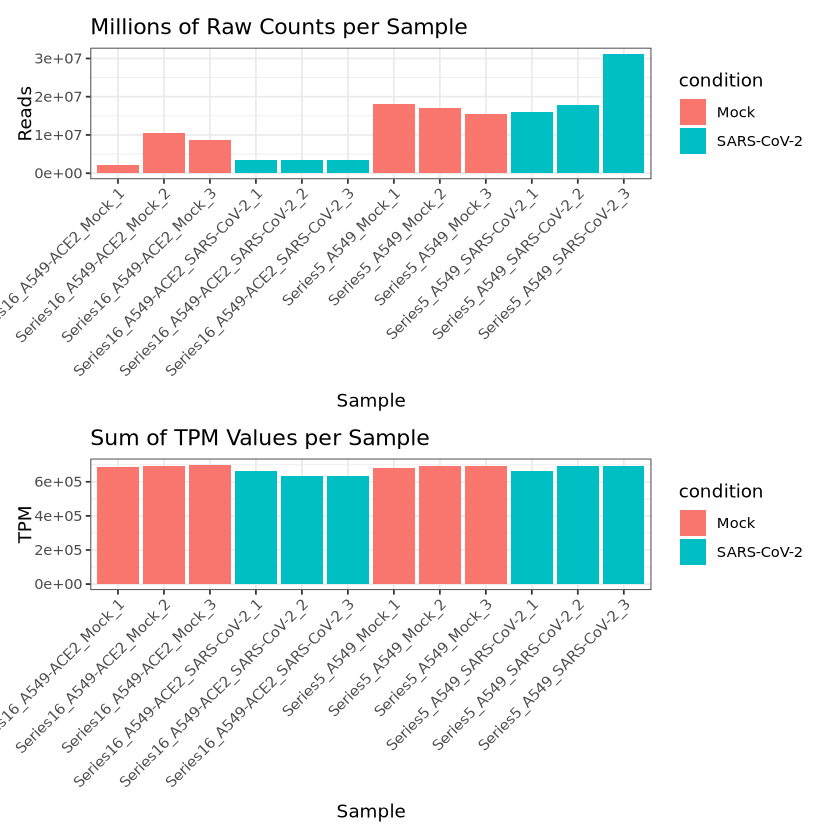

In [15]:
# Create counts barplot to visualize total counts per sample
p1 <- ggplot(millions_counts_df, aes(x = sample, y = millions, fill = condition)) +
  geom_bar(stat = "identity") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(
    title = "Millions of Raw Counts per Sample",
    x = "Sample",
    y = "Reads"
  )

# Create TPM barplot
p2 <- ggplot(millions_tpm_df, aes(x = sample, y = millions, fill = condition)) +
  geom_bar(stat = "identity") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(
    title = "Sum of TPM Values per Sample",
    x = "Sample",
    y = "TPM"
  )

# Display plots one above the other
p1 / p2


### Key Observations:

1. **Library Size Differences**: Notice how raw counts vary between samples.
   These differences are technical, not biological, and must be normalized.

2. **TPM Normalization**: TPM values should sum to exactly 1,000,000 per sample in the full dataset. Here we see sums of approximately 680,000-700,000 TPM per sample because we've filtered to only include protein-coding genes, which represent ~68-70% of the total transcriptome. This demonstrates an important biological reality - a significant portion of the transcriptome consists of non-coding RNAs.

4. **Normalization Impact**: Normalization can dramatically change our conclusions
   about which genes are differentially expressed.


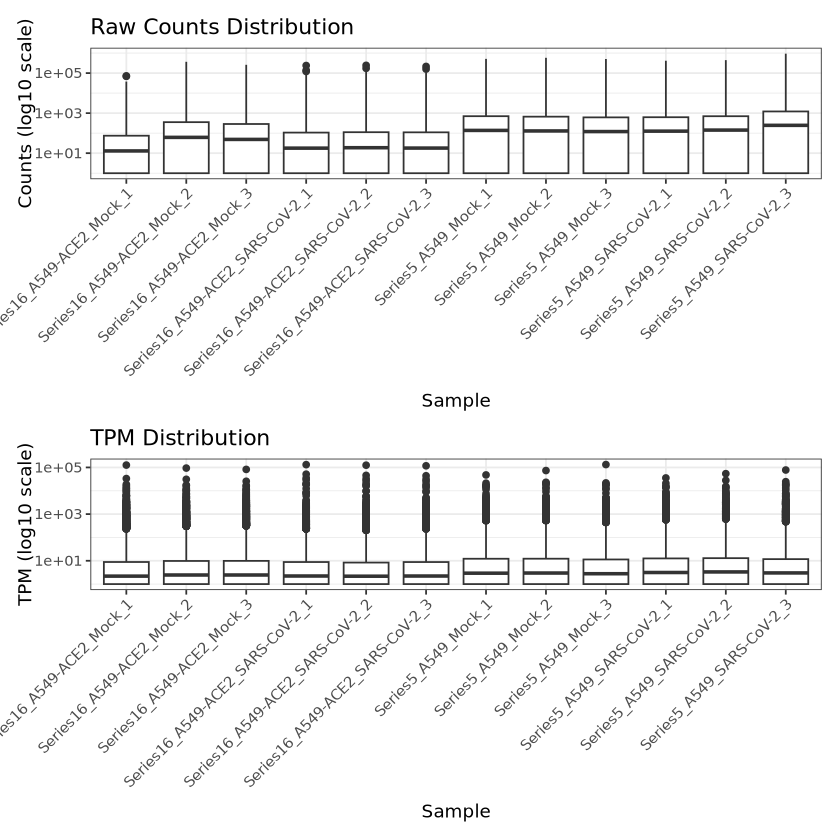

In [16]:
# Look at raw counts distributions using boxplots
counts_df <- as.data.frame(txi$counts) %>%
  rownames_to_column("gene_id") %>%
  pivot_longer(-gene_id, 
               names_to = "sample", 
               values_to = "counts")

tpm_df <- as.data.frame(txi$abundance) %>%
  rownames_to_column("gene_id") %>%
  pivot_longer(-gene_id, 
               names_to = "sample", 
               values_to = "tpm")

# Create boxplots for both metrics
p1 <- ggplot(counts_df, aes(x=sample, y=counts + 1)) + 
  geom_boxplot() +
  scale_y_log10() +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Raw Counts Distribution",
       y = "Counts (log10 scale)",
       x = "Sample")

p2 <- ggplot(tpm_df, aes(x=sample, y=tpm + 1)) + 
  geom_boxplot() +
  scale_y_log10() +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "TPM Distribution",
       y = "TPM (log10 scale)",
       x = "Sample")

# Display plots
p1 / p2


### Distribution Analysis:

- Count distributions vary between samples - not just in total counts,
  but in the shape of the distribution
- The +1 is added to allow log transformation (log of 0 is undefined)
- TPM normalization makes distributions more comparable, but differences remain
- These differences highlight why simple statistical tests can be problematic

## 4. Simple Statistical Analysis

### Simple Statistical Approach: t-tests

Let's first try a simple approach - t-tests on TPM values.
We'll see why this approach has limitations for RNA-seq data.


In [17]:
# Calculate TPM values (we'll use the abundance values from tximport)
tpm <- txi$abundance

# Reshape data for t-tests
tidy_tpm <- as_tibble(tpm, rownames = "gene") %>%
  pivot_longer(-gene, 
               names_to = "sample", 
               values_to = "tpm") %>%
  mutate(condition = ifelse(grepl("Mock", sample), "Mock", "SARS-CoV-2"))

# Run t-tests for all genes
t_test_results <- tidy_tpm %>%
  group_by(gene) %>%
  t_test(tpm ~ condition) %>%
  select(gene, statistic, p) %>%
  rename(pvalue = p)

# Calculate means, fold changes and other metrics
test_data <- tidy_tpm %>%
  group_by(gene) %>%
  summarise(
    mean_mock = mean(tpm[condition == "Mock"]),
    mean_sars = mean(tpm[condition == "SARS-CoV-2"]),
    var_mock = var(tpm[condition == "Mock"]),
    var_sars = var(tpm[condition == "SARS-CoV-2"])
  ) %>%
  # Add gene symbols
  left_join(
    tibble(
      gene = tx2gene$GENEID,
      symbol = tx2gene$SYMBOL
    ),
    by = "gene"
  ) %>%
  # Add t-test results
  left_join(t_test_results, by = "gene") %>%
  # Calculate MA plot values and other metrics
  mutate(
    M = log2(mean_sars/mean_mock),
    A = log2((mean_sars + mean_mock)/2),
    log2FC = M,
    mean_expr = (mean_mock + mean_sars)/2,
    padj = p.adjust(pvalue, method = "BH")
  )

# Sort by adjusted p-value
sorted_data <- test_data %>%
  arrange(padj, desc(abs(log2FC))) %>%  # First by padj, then by absolute log2FC magnitude
  distinct(symbol, .keep_all = TRUE) %>%  # Keep only one row per gene symbol
  mutate(rank = row_number())  # Add rank column

# Look at top genes
head(sorted_data %>% 
     select(rank, symbol, mean_expr, log2FC, pvalue, padj), 20)


rank,symbol,mean_expr,log2FC,pvalue,padj
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,NUDC,55.059323,-1.1855993,2.05e-08,0.0006780117
2,SNRPA1,36.595874,-1.0729531,2.29e-08,0.0006780117
3,ICAM1,31.091218,2.1454278,6.87e-08,0.0007401875
4,CTNNAL1,28.384973,1.0771780,1.00e-07,0.0007401875
5,ALDH4A1,6.297082,-1.8912340,2.56e-07,0.0008421689
6,RELB,17.857702,1.7042224,1.59e-07,0.0008421689
7,PPP3CC,5.469176,0.7160892,2.16e-07,0.0008421689
8,SERPINA6,2.607884,-2.1305662,2.77e-07,0.0008632924
9,CD55,47.833182,1.5148376,4.73e-07,0.0009035063


### Challenges with Simple t-tests:

1. They don't account for the mean-variance relationship in RNA-seq data
2. Low-count genes often show artificially high fold changes
3. Multiple testing correction (p.adjust) helps, but doesn't address fundamental issues
4. Different normalization methods can produce different results

## 5. Visualizing RNA-seq Data Characteristics

### Understanding RNA-seq Data Characteristics

Let's visualize key characteristics of RNA-seq data that
make specialized methods necessary.



Warning message:
“Removed 3745 rows containing missing values or values outside the scale range
(`geom_point()`).”


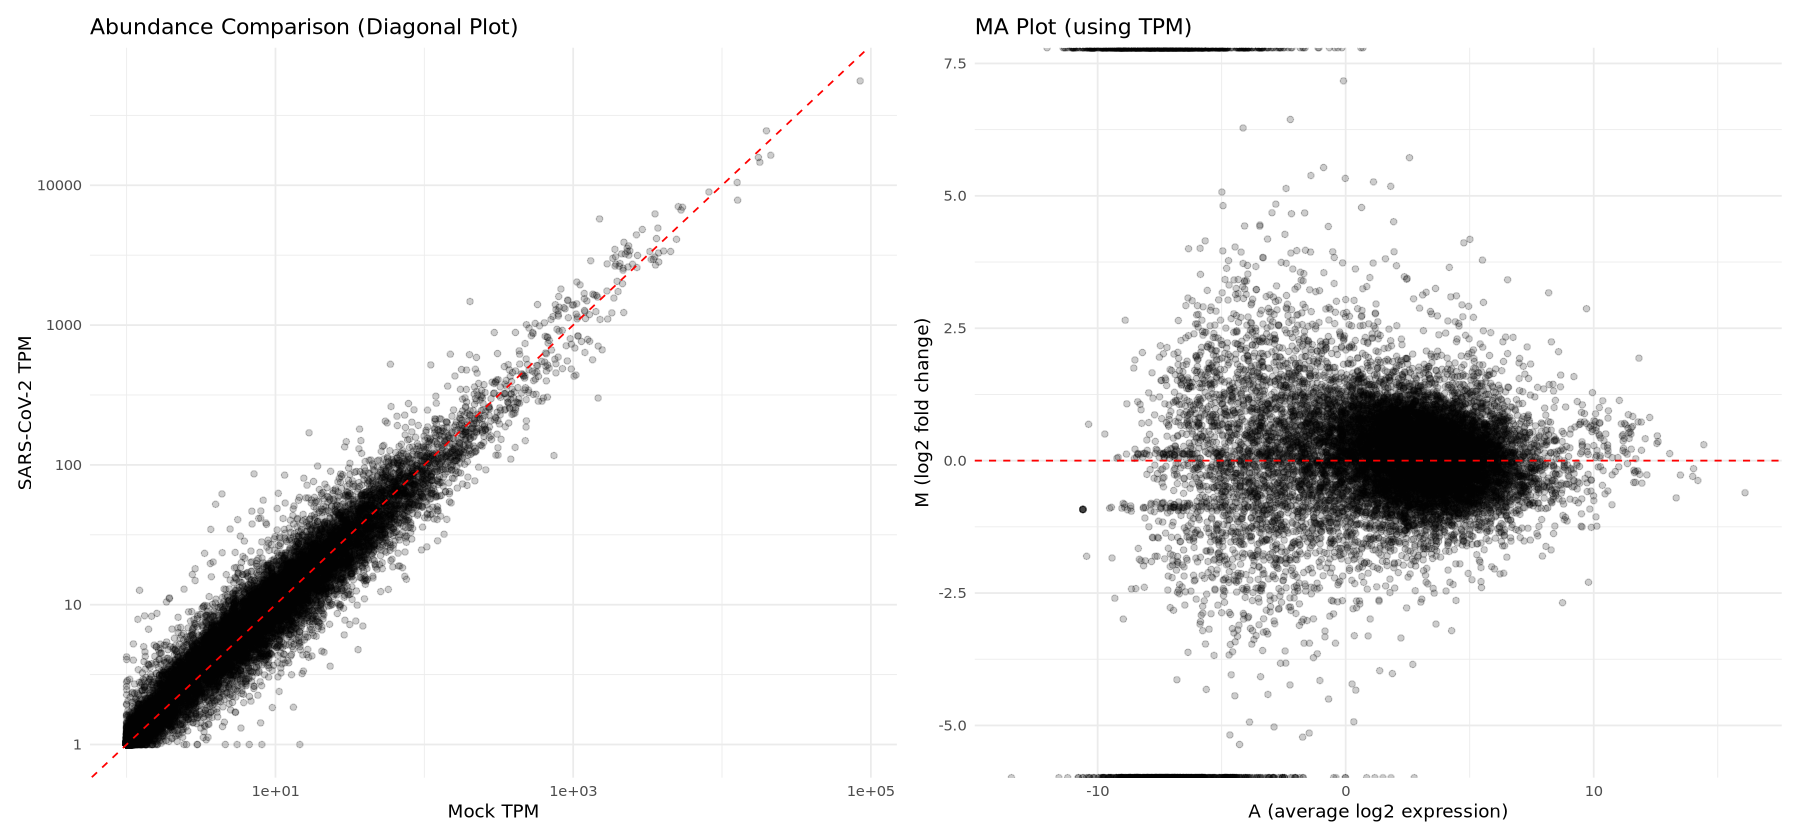

In [18]:
# Set plot size
options(repr.plot.width=15, repr.plot.height=7)

# Calculate means for SARS-CoV-2 and Mock conditions
mock_abund <- txi$abundance[, grep("Series5_A549_Mock", colnames(txi$abundance))]
sars_abund <- txi$abundance[, grep("Series5_A549_SARS-CoV-2", colnames(txi$abundance))]
mean_mock <- rowMeans(mock_abund)
mean_sars <- rowMeans(sars_abund)

# Create dataframe for plotting
plot_data <- data.frame(
    gene = rownames(txi$abundance),
    mean_mock = mean_mock,
    mean_sars = mean_sars,
    M = log2(mean_sars/mean_mock),
    A = log2((mean_sars + mean_mock)/2)
)

# Create two plots side by side
p1 <- ggplot(plot_data, aes(x = mean_mock + 1, y = mean_sars + 1)) +
    geom_point(alpha = 0.2) +
    geom_abline(color = "red", linetype = "dashed") +
    scale_x_log10() +
    scale_y_log10() +
    theme_minimal() +
    labs(title = "Abundance Comparison (Diagonal Plot)",
         x = "Mock TPM",
         y = "SARS-CoV-2 TPM")

p2 <- ggplot(plot_data, aes(x = A, y = M)) +
    geom_point(alpha = 0.2) +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
    theme_minimal() +
    labs(title = "MA Plot (using TPM)",
         x = "A (average log2 expression)",
         y = "M (log2 fold change)")

p1 + p2


### Key RNA-seq Data Characteristics:

- **Diagonal Plot**: Shows correlation between conditions. Points far from
  the diagonal represent potentially differentially expressed genes.
  
- **MA Plot**: Popular in RNA-seq analysis. Shows log fold change (M) vs
  average expression (A). Note how low-abundance genes (left side) 
  show much more variable fold changes.
  
- **Heteroscedasticity**: The variance is not constant across expression levels!
  This violates a key assumption of t-tests.


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 7325 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Failed to fit group -1.
Caused by error in `predLoess()`:
! workspace required (4981897419) is too large probably because of setting 'se = TRUE'.”
Warning message:
“Removed 5737 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5737 rows containing missing values or values outside the scale range
(`geom_point()`).”


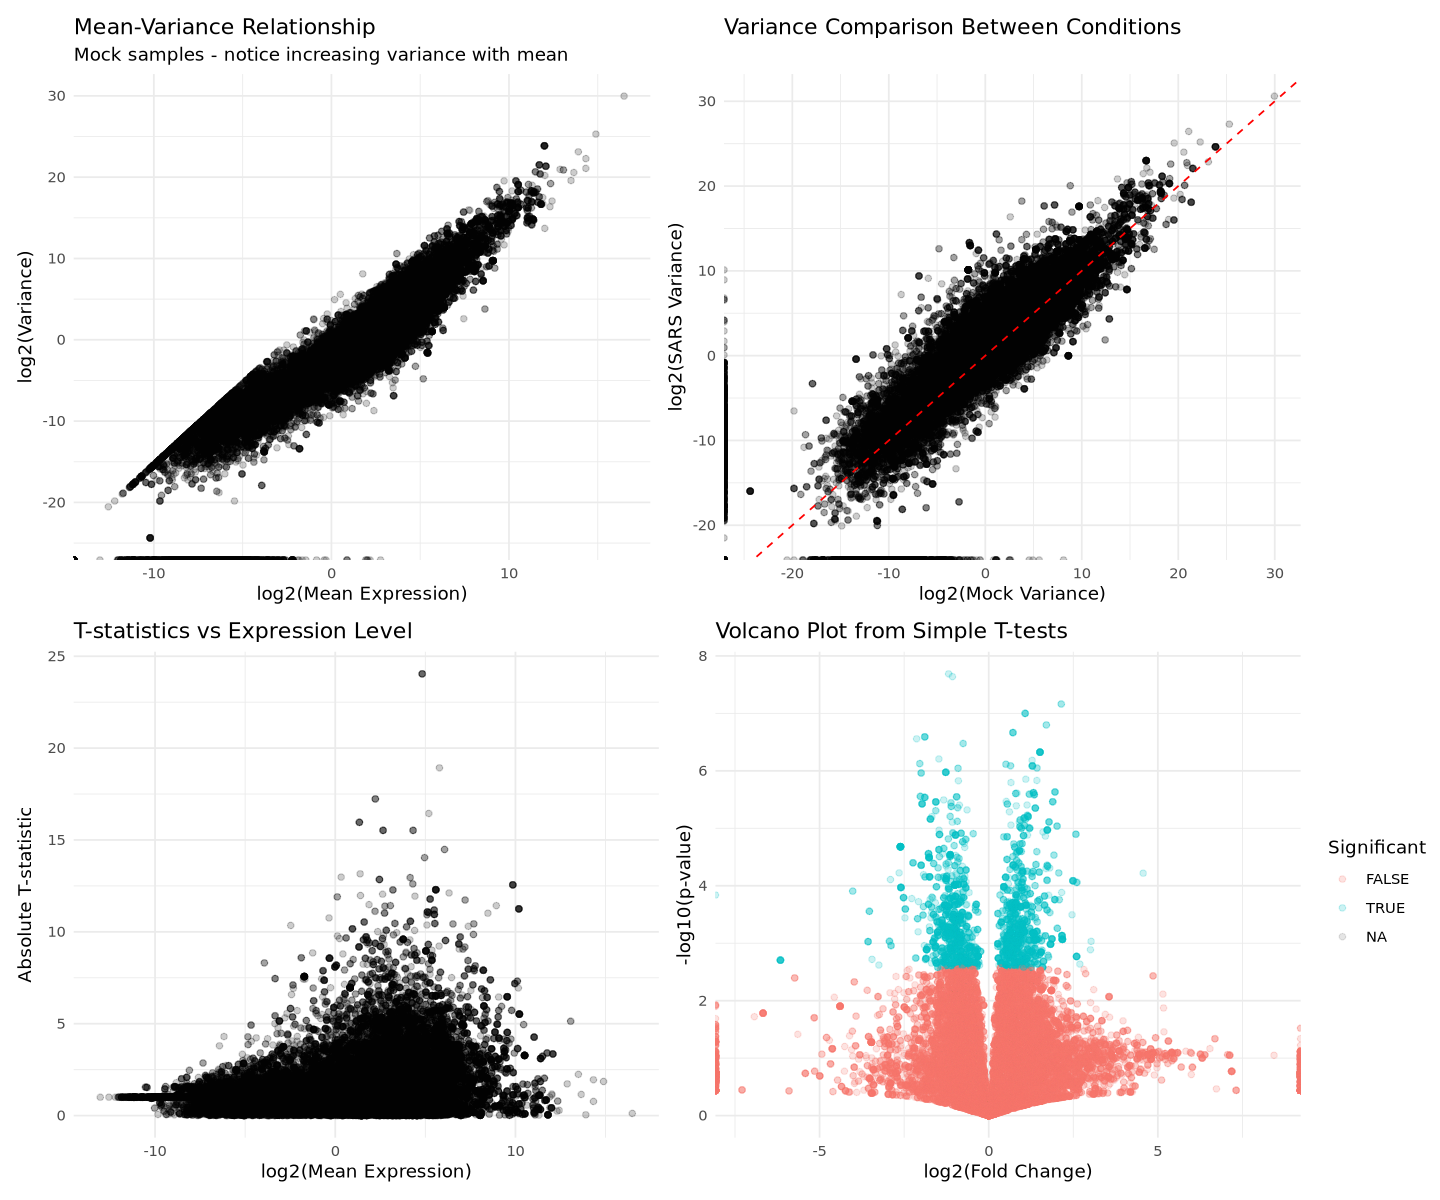

In [19]:
# Set plot size
options(repr.plot.width=12, repr.plot.height=10)

# Visualize RNA-seq data characteristics

# 1. Mean-Variance relationship
p1 <- ggplot(test_data, aes(x = log2(mean_expr), y = log2(var_mock))) +
   geom_point(alpha = 0.2) +
   geom_smooth(method = "loess", color = "red") +
   theme_minimal() +
   labs(title = "Mean-Variance Relationship",
        subtitle = "Mock samples - notice increasing variance with mean",
        x = "log2(Mean Expression)",
        y = "log2(Variance)")

# 2. Compare variance between conditions
p2 <- ggplot(test_data, aes(x = log2(var_mock), y = log2(var_sars))) +
   geom_point(alpha = 0.2) +
   geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
   theme_minimal() +
   labs(title = "Variance Comparison Between Conditions",
        x = "log2(Mock Variance)",
        y = "log2(SARS Variance)")

# 3. T-statistics vs Expression Level
p3 <- ggplot(test_data, aes(x = log2(mean_expr), y = abs(statistic))) +
   geom_point(alpha = 0.2) +
   theme_minimal() +
   labs(title = "T-statistics vs Expression Level",
        x = "log2(Mean Expression)",
        y = "Absolute T-statistic")

# 4. Volcano plot
p4 <- ggplot(test_data, aes(x = log2FC, y = -log10(pvalue))) +
   geom_point(alpha = 0.2, aes(color = padj < 0.05)) +
   theme_minimal() +
   labs(title = "Volcano Plot from Simple T-tests",
        x = "log2(Fold Change)",
        y = "-log10(p-value)",
        color = "Significant")

# Using patchwork to display all plots
(p1 + p2) / (p3 + p4)


### Critical Observations:

1. **Mean-Variance Relationship**: Variance increases with expression level.
   This is a fundamental property of count data that simple statistical
   methods don't account for.
   
2. **Heteroscedasticity**: Both conditions show similar patterns of
   heteroscedasticity (non-constant variance).
   
3. **T-statistic Bias**: T-statistics show concerning patterns with
   expression level, suggesting potential biases.
   
4. **Volcano Plot**: Shows genes with both statistical significance
   and biological significance (fold change). But are these results reliable?

## 6. Normalization Comparison

### Comparing Normalization Methods

Let's compare different normalization approaches:
- Raw counts
- RPKM (Reads Per Kilobase Million)
- TPM (Transcripts Per Million)

Each has strengths and limitations for RNA-seq analysis.


Warning message:
“Removed 3745 rows containing missing values or values outside the scale range
(`geom_point()`).”


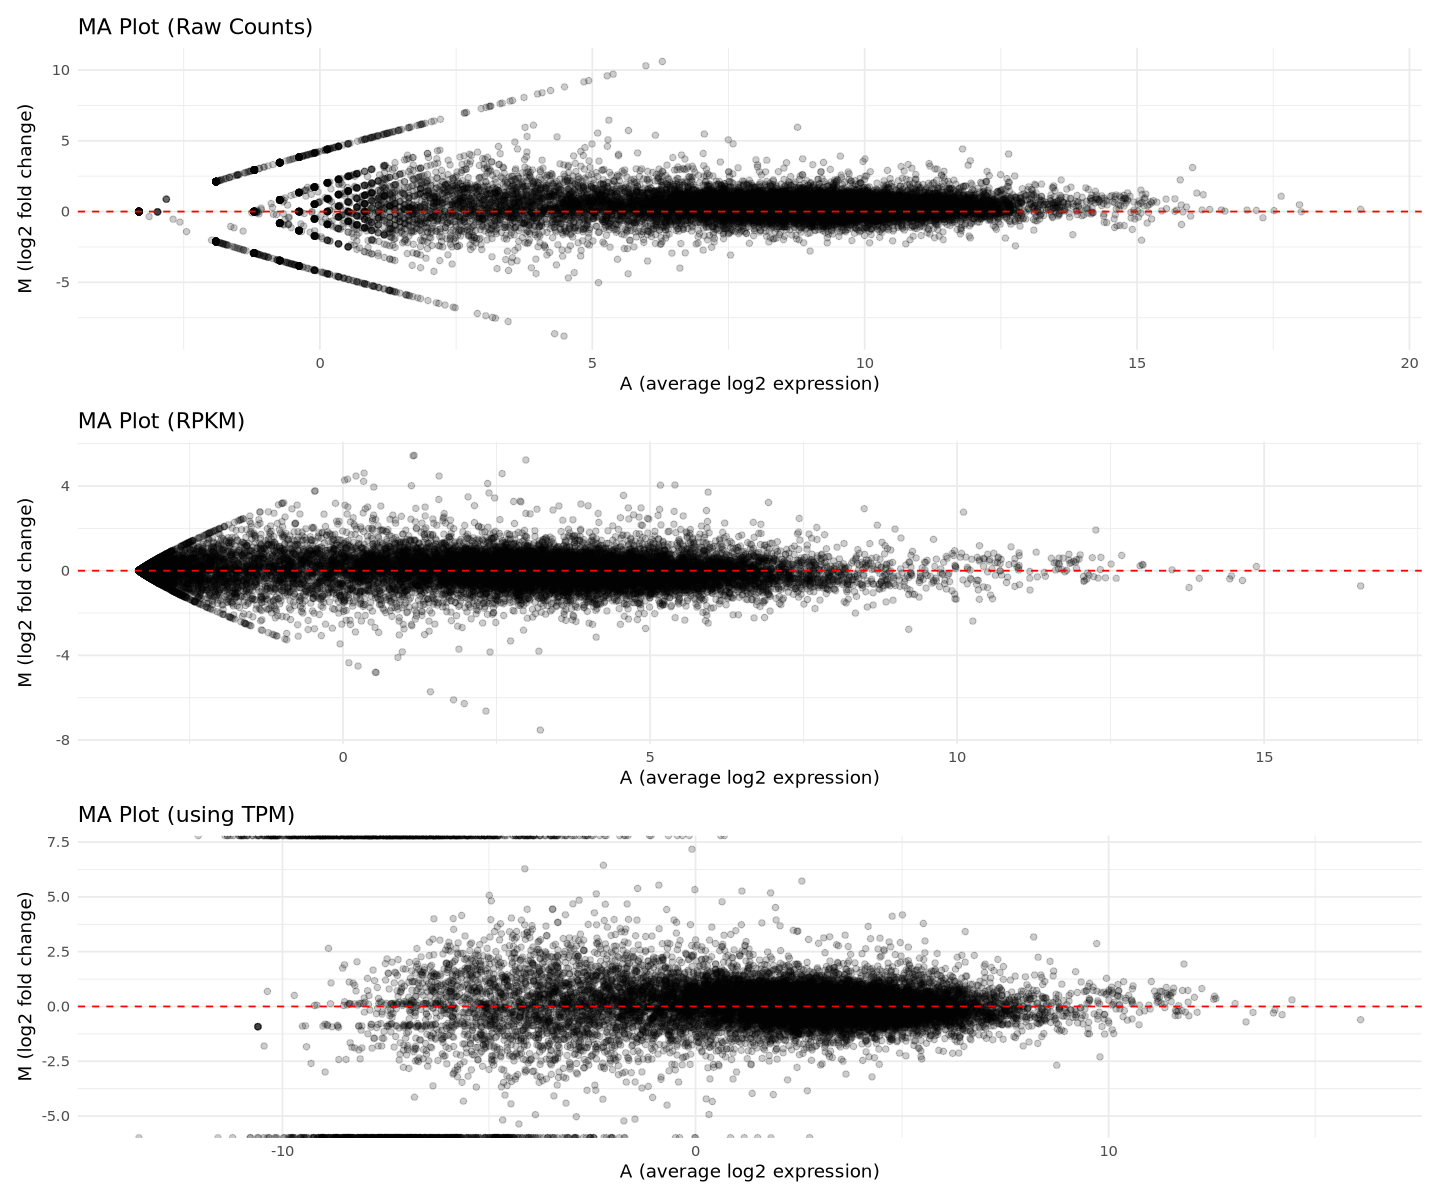

In [20]:
# Get gene lengths from txi
gene_lengths <- txi$length[,1]  # take first sample's lengths

# Calculate RPKM
# First get counts
mock_counts <- txi$counts[, grep("Series5_A549_Mock", colnames(txi$counts))]
sars_counts <- txi$counts[, grep("Series5_A549_SARS-CoV-2", colnames(txi$counts))]

# Calculate library sizes
lib_size_mock <- colSums(mock_counts)/1e6  # in millions
lib_size_sars <- colSums(sars_counts)/1e6

# Calculate RPKM
rpkm_mock <- t(t(mock_counts) / lib_size_mock) / (gene_lengths/1000)
rpkm_sars <- t(t(sars_counts) / lib_size_sars) / (gene_lengths/1000)

# Calculate means for both metrics
mean_mock_counts <- rowMeans(mock_counts)
mean_sars_counts <- rowMeans(sars_counts)
mean_mock_rpkm <- rowMeans(rpkm_mock)
mean_sars_rpkm <- rowMeans(rpkm_sars)

# Create plot data for MA plots
plot_data_counts <- data.frame(
    M = log2((mean_sars_counts + 0.1)/(mean_mock_counts + 0.1)),
    A = log2((mean_sars_counts + mean_mock_counts + 0.2)/2)
)

plot_data_rpkm <- data.frame(
    M = log2((mean_sars_rpkm + 0.1)/(mean_mock_rpkm + 0.1)),
    A = log2((mean_sars_rpkm + mean_mock_rpkm + 0.2)/2)
)

# Create plots
p1 <- ggplot(plot_data_counts, aes(x = A, y = M)) +
    geom_point(alpha = 0.2) +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
    theme_minimal() +
    labs(title = "MA Plot (Raw Counts)",
         x = "A (average log2 expression)",
         y = "M (log2 fold change)")

p2 <- ggplot(plot_data_rpkm, aes(x = A, y = M)) +
    geom_point(alpha = 0.2) +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
    theme_minimal() +
    labs(title = "MA Plot (RPKM)",
         x = "A (average log2 expression)",
         y = "M (log2 fold change)")

# tpm MvA plot was calculated earlier above
p3 <- ggplot(plot_data, aes(x = A, y = M)) +
    geom_point(alpha = 0.2) +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
    theme_minimal() +
    labs(title = "MA Plot (using TPM)",
         x = "A (average log2 expression)",
         y = "M (log2 fold change)")

# Display as a stack of plots
p1/p2/p3 


### Normalization Comparison:

- **Raw Counts**: Don't account for sequencing depth or gene length
- **RPKM**: Normalizes for sequencing depth and gene length
- **TPM**: Similar to RPKM but normalizes so values sum to the same number across samples

**Critical insight**: Different normalization methods can lead to different conclusions
about which genes are differentially expressed. None of these methods fully
address the heteroscedasticity issue.

## 7. DESeq2 Analysis

### Advanced Analysis with DESeq2

Now let's use DESeq2, which addresses many limitations of simpler approaches:

1. Uses negative binomial model appropriate for count data
2. Estimates dispersion for each gene, addressing heteroscedasticity
3. Applies variance stabilizing transformations
4. Uses shrinkage to improve estimates for low-count genes
5. Sophisticated normalization approach (size factors)


In [21]:
# Create DESeq2 object from tximport data
dds <- DESeqDataSetFromTximport(txi,
                               colData = sample_info,
                               design = ~ cell_type + condition + cell_type:condition)

# Set factor levels
dds$condition <- relevel(dds$condition, ref = "Mock")
dds$cell_type <- relevel(dds$cell_type, ref = "A549")

# Run DESeq2
dds <- DESeq(dds)

# Get various results
# 1. Effect of virus in regular A549 cells
res_a549 <- results(dds, 
                   contrast = c("condition", "SARS-CoV-2", "Mock"),
                   alpha = 0.05)

# 2. Effect of virus in ACE2-expressing cells
res_ace2 <- results(dds, 
                   contrast = list(
                       c("condition_SARS.CoV.2_vs_Mock", 
                         "cell_typeA549.ACE2.conditionSARS.CoV.2")))

# 3. Interaction effect (difference in virus effect between cell types)
res_interaction <- results(dds, 
                         name="cell_typeA549.ACE2.conditionSARS.CoV.2")

# Order results by adjusted p-value
res_a549 <- res_a549[order(res_a549$padj), ]
res_ace2 <- res_ace2[order(res_ace2$padj), ]
res_interaction <- res_interaction[order(res_interaction$padj), ]

# Print summaries
cat("Virus effect in A549 cells:\n")
print(summary(res_a549))
cat("\nVirus effect in A549-ACE2 cells:\n")
print(summary(res_ace2))
cat("\nInteraction effect:\n")
print(summary(res_interaction))


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using counts and average transcript lengths from tximport

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of fact

Virus effect in A549 cells:

out of 17131 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3071, 18%
LFC < 0 (down)     : 3190, 19%
outliers [1]       : 33, 0.19%
low counts [2]     : 2634, 15%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL

Virus effect in A549-ACE2 cells:

out of 17131 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4163, 24%
LFC < 0 (down)     : 4063, 24%
outliers [1]       : 33, 0.19%
low counts [2]     : 2634, 15%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL

Interaction effect:

out of 17131 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3518, 21%
LFC < 0 (down)     : 3287, 19%
outliers [1]       : 33, 0.19%
low counts [2]     : 2634, 15%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?res

### DESeq2 Analysis Results:

DESeq2 results show:
- The number of up- and down-regulated genes
- Genes flagged for low counts
- Genes with high variability

These results address many limitations of the t-test approach,
providing more reliable differential expression results.


In [22]:
# After running DESeq2 and getting the results (res_a549)
# Convert DESeq2 results to a data frame and add gene symbols
res_df <- as.data.frame(res_a549)
res_df$GENEID <- rownames(res_df)

# Get gene info for annotation
gene_info <- unique(tx2gene[, c("GENEID", "SYMBOL", "GENE_TYPE")])

# Merge results with gene info
res_annotated <- merge(res_df, gene_info, by="GENEID", all.x=TRUE)

# Order by adjusted p-value
res_annotated <- res_annotated[order(res_annotated$padj), ]

# Remove duplicates if needed
res_annotated <- res_annotated %>%
  distinct(SYMBOL, .keep_all = TRUE)

# Display the top genes in a table format
# Select only the most relevant columns
top_genes <- res_annotated %>%
  filter(!is.na(padj)) %>%
  select(SYMBOL, baseMean, log2FoldChange, lfcSE, stat, pvalue, padj) %>%
  head(20)

# Print the table
print(top_genes)

# Add some basic stats
alpha <- 0.05
sig_genes <- sum(!is.na(res_annotated$padj) & res_annotated$padj < alpha)
sig_up <- sum(!is.na(res_annotated$padj) & res_annotated$padj < alpha & res_annotated$log2FoldChange > 0)
sig_down <- sum(!is.na(res_annotated$padj) & res_annotated$padj < alpha & res_annotated$log2FoldChange < 0)

cat("Total significant genes (padj <", alpha, "):", sig_genes, "\n")
cat("Up-regulated:", sig_up, "\n")
cat("Down-regulated:", sig_down, "\n")

     SYMBOL   baseMean log2FoldChange      lfcSE      stat        pvalue
1      STC2  3449.8665       4.066269 0.10999647  36.96727 3.846021e-299
2     ICAM1  1133.4508       2.808179 0.09850400  28.50827 9.250390e-179
3     LAMC2  1497.8494       3.677157 0.13467347  27.30424 3.777308e-164
4      FASN  1862.0000      -2.240603 0.08210675 -27.28890 5.744419e-164
5    DHCR24  1021.5730      -2.060994 0.07564851 -27.24434 1.939508e-163
6  SERPINE1 26583.1571       2.755828 0.10966856  25.12870 2.416347e-139
7     CXCL8  9372.6471       2.219647 0.08837308  25.11677 3.261668e-139
8      EREG  1675.2443       2.985207 0.12222135  24.42460 9.372194e-132
9  C15orf48  1015.5931       3.063377 0.12604815  24.30323 1.811943e-130
10    BIRC3  1409.6293       1.879970 0.07805862  24.08408 3.670857e-128
11     MCM5   522.8172      -2.361249 0.10251947 -23.03220 2.218312e-117
12  TMEM156   507.9777       2.436903 0.10595311  22.99983 4.680032e-117
13    CDCP1  1094.3063       2.620476 0.11488576  2

## 8. Visualization of DESeq2 Results

### Visualizing DESeq2 Results

Let's create professional visualizations of our DESeq2 results.



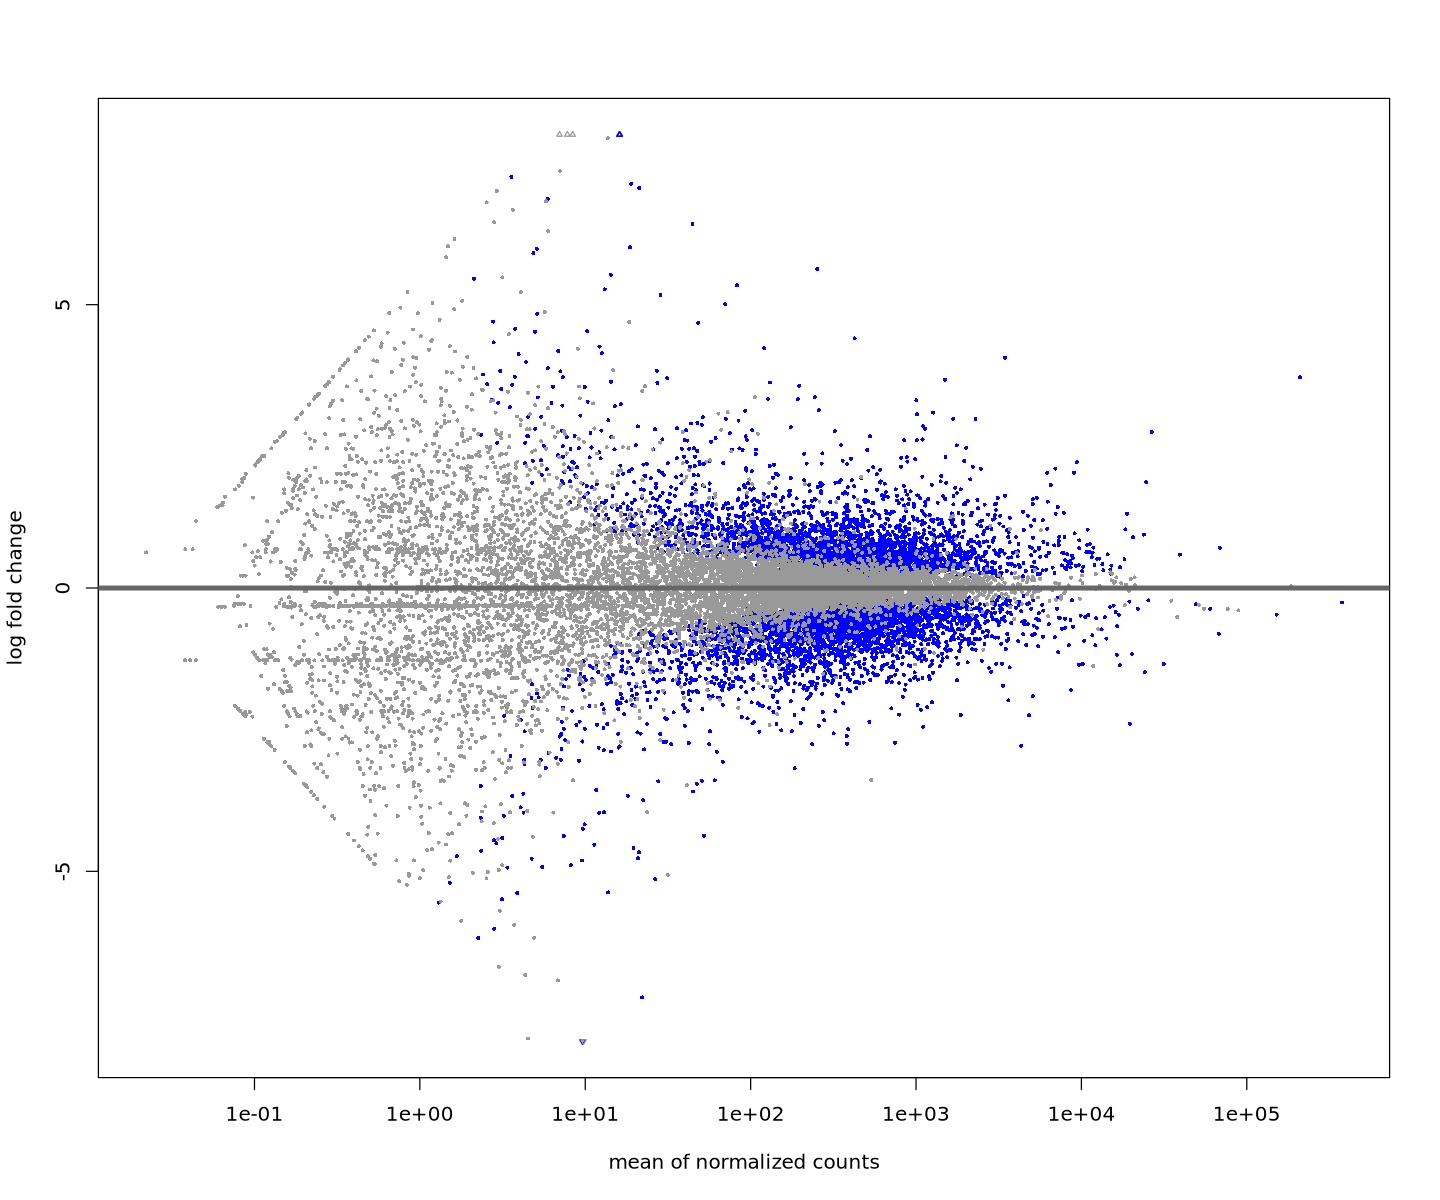

In [23]:
# Create MA plot
plotMA(res_a549, ylim=c(-8,8))


Warning message:
“ggrepel: 1756 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


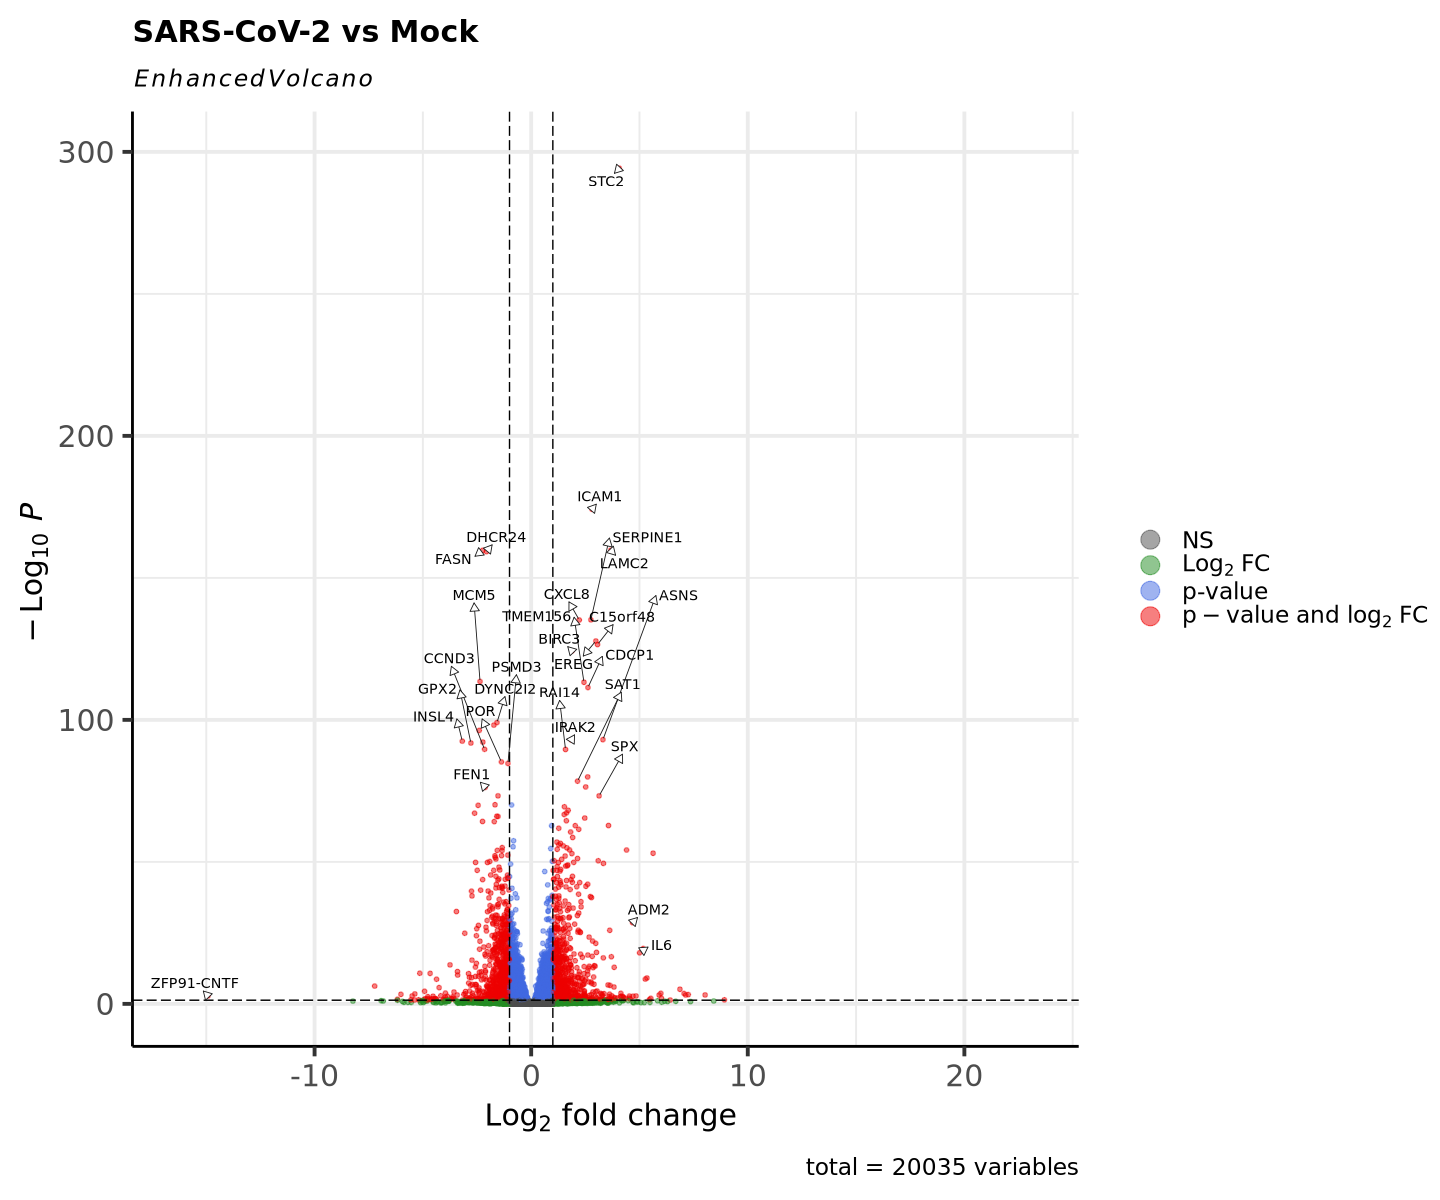

In [24]:
# Create a more sophisticated volcano plot with EnhancedVolcano
library(EnhancedVolcano)

# Convert results to dataframe and add gene info
res_df <- as.data.frame(res_a549)
res_df$GENEID <- rownames(res_df)

# Add gene symbols from tx2gene
gene_info <- unique(tx2gene[, c("GENEID", "SYMBOL")])
res_df <- merge(res_df, gene_info, by="GENEID", all.x=TRUE)

# Create volcano plot
EnhancedVolcano(res_df,
    lab = res_df$SYMBOL,
    x = 'log2FoldChange',
    y = 'padj',
    title = 'SARS-CoV-2 vs Mock',
    pCutoff = 0.05,
    FCcutoff = 1,
    pointSize = 1.0,
    labSize = 3.0,
    legendPosition = 'right',
    drawConnectors = TRUE,
    widthConnectors = 0.25)


### DESeq2 Visualizations:

- **MA Plot**: Shows log fold change vs mean expression. Notice how DESeq2
  shrinks fold changes for low-count genes, addressing a key limitation of simple methods.
  
- **Volcano Plot**: Highlights genes with both statistical significance and
  biological relevance (high fold change).
  
- Both plots show more reliable results than our simple t-test approach.

## 9. Advanced Visualization - Heatmap

### Advanced Visualization: Heatmap

Let's create a heatmap of the top differentially expressed genes.



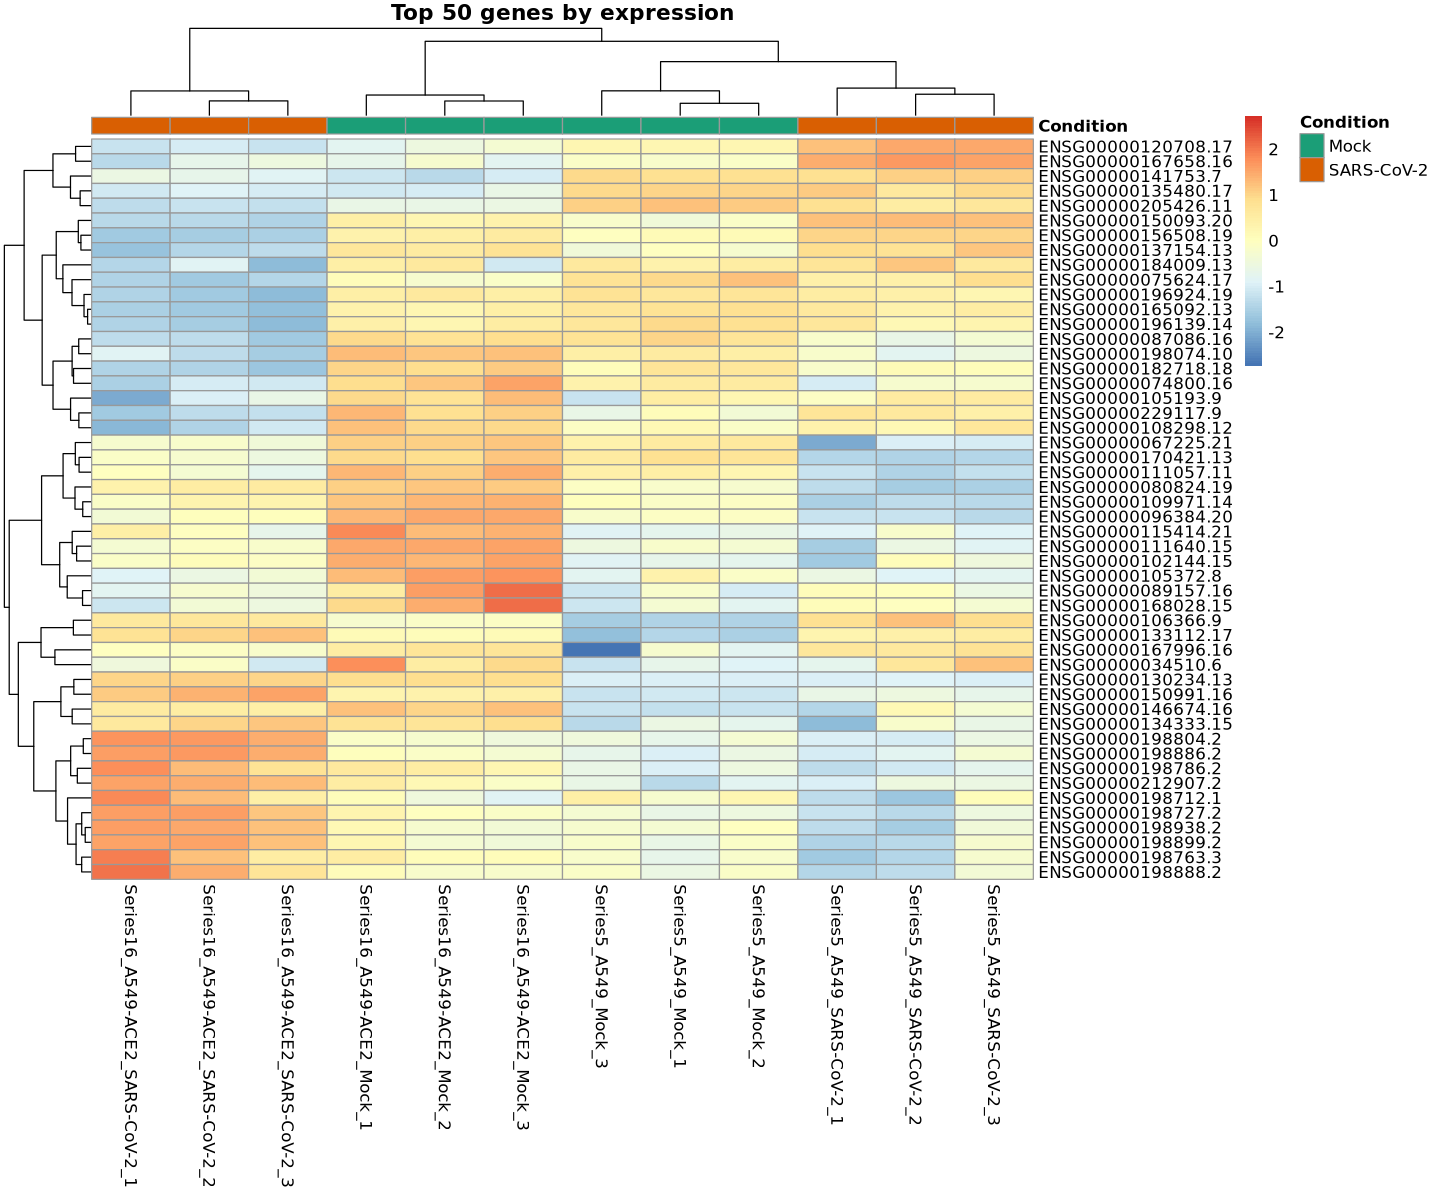

In [25]:
# Use variance stabilizing transformation for better visualization
vsd <- vst(dds, blind=FALSE)

# Select top genes by mean expression
select <- order(rowMeans(counts(dds,normalized=TRUE)),
               decreasing=TRUE)[1:50]
mat <- assay(vsd)[select,]

# Prepare annotation data
annotation_col <- data.frame(
    Condition = sample_info$condition,
    row.names = rownames(sample_info)
)

# Define colors explicitly
ann_colors <- list(
    Condition = c(Mock = "#1B9E77", "SARS-CoV-2" = "#D95F02")
)

# Create heatmap with explicit color settings
pheatmap(mat,
         annotation_col = annotation_col,
         annotation_colors = ann_colors,
         show_rownames = TRUE,
         show_colnames = TRUE,
         scale = "row",
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         main = "Top 50 genes by expression")


### Heatmap Interpretation:

- Rows represent genes, columns represent samples
- Color indicates expression level (red = high, blue = low)
- Dendrograms show clustering of similar genes and samples
- Notice how samples cluster by condition (Mock vs. SARS-CoV-2)
- The heatmap reveals patterns not visible in other visualizations

## 10. Functional Enrichment Analysis

### Biological Interpretation: Functional Enrichment

Let's analyze the biological functions enriched in our differentially expressed genes.



In [26]:
install.packages("gprofiler2")


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [27]:
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(gprofiler2)



clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:clusterProfiler’:

    select


The following object is masked from ‘package:rstatix’:

    select


The following object is masked from ‘package:dplyr’:

    select






Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (5.23% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


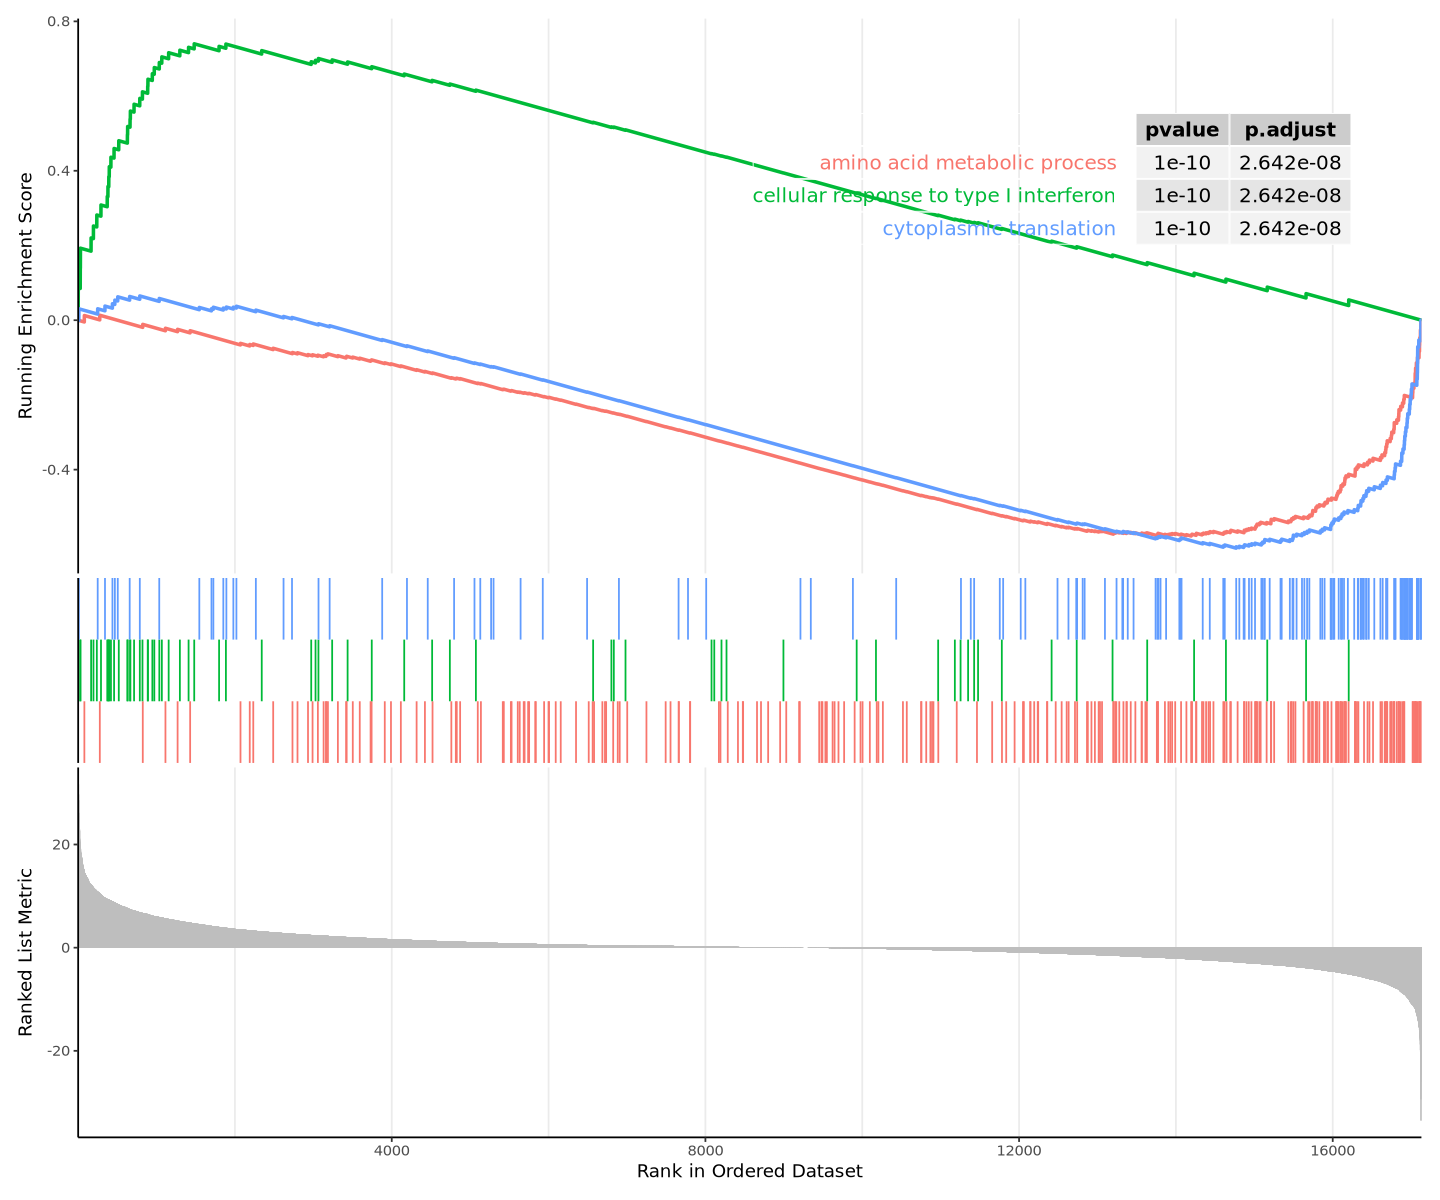

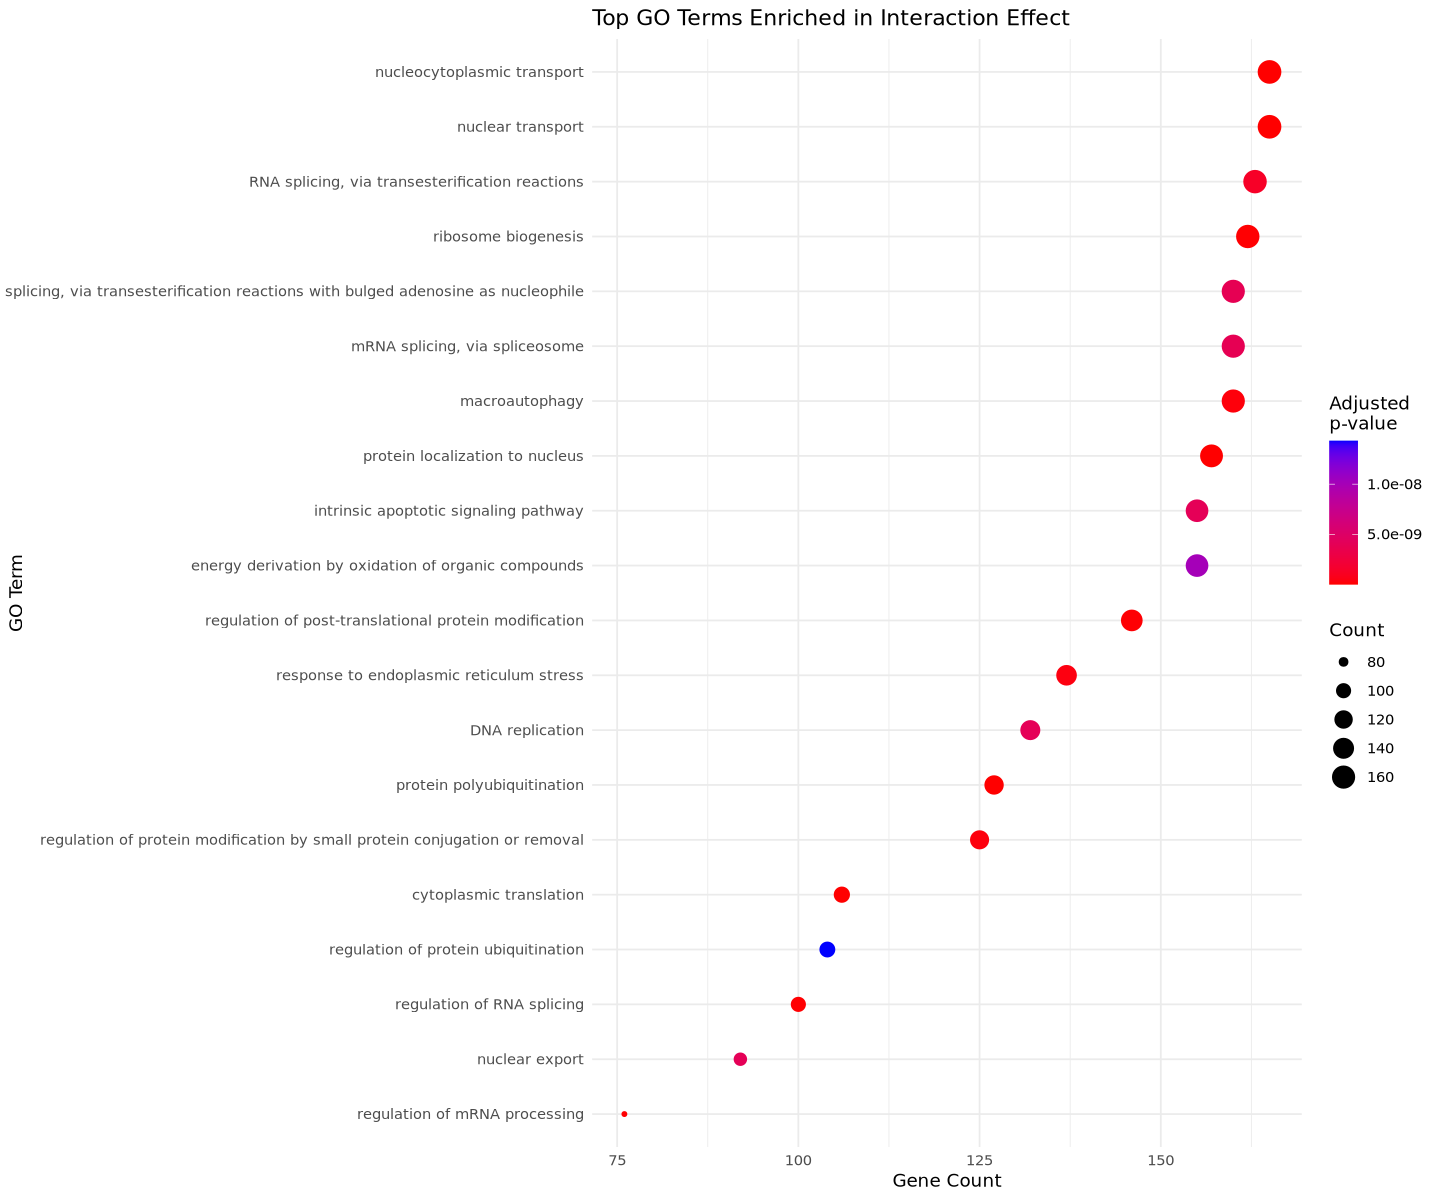

In [28]:


# Let's prepare our results for enrichment analysis
# First for the interaction results
interaction_results <- as.data.frame(res_interaction) %>%
  rownames_to_column("ENSEMBL") %>%
  # Filter for significant genes
  filter(!is.na(padj), padj < 0.05) %>%
  # Remove version numbers if needed
  mutate(ENSEMBL = str_replace(ENSEMBL, "\\.[0-9]*$", ""))

# Get significant genes ordered by fold change
interaction_genes <- interaction_results %>%
  arrange(desc(log2FoldChange)) %>%
  pull(ENSEMBL)

# Run GO enrichment
ego <- enrichGO(gene = interaction_genes,
                OrgDb = org.Hs.eg.db,
                keyType = "ENSEMBL",
                ont = "BP",  # Biological Process
                pAdjustMethod = "BH",
                pvalueCutoff = 0.05)

# Create a nice visualization
# Dotplot of top enriched terms
dotplot_go <- ego %>%
  as_tibble() %>%
  slice_head(n = 20) %>%  # Top 20 terms
  ggplot(aes(x = Count, y = reorder(Description, Count))) +
  geom_point(aes(size = Count, color = p.adjust)) +
  scale_color_gradient(low = "red", high = "blue") +
  theme_minimal() +
  labs(x = "Gene Count",
       y = "GO Term",
       title = "Top GO Terms Enriched in Interaction Effect",
       color = "Adjusted\np-value")

# For GSEA, we'll need to create a ranked list
gsea_ranking <- res_interaction %>%
  as.data.frame() %>%
  rownames_to_column("ENSEMBL") %>%
  filter(!is.na(stat)) %>%
  mutate(ENSEMBL = str_replace(ENSEMBL, "\\.[0-9]*$", "")) %>%
  arrange(desc(stat)) %>%
  pull(stat, name = ENSEMBL)

# Run GSEA
gse <- gseGO(geneList = gsea_ranking,
             OrgDb = org.Hs.eg.db,
             keyType = "ENSEMBL",
             ont = "BP",
             minGSSize = 10,
             maxGSSize = 500,
             pvalueCutoff = 0.05,
             verbose = FALSE)

# Visualize GSEA results
gsea_plot <- gseaplot2(gse, geneSetID = 1:3, pvalue_table = TRUE)

# Display plots
print(gsea_plot)
print(dotplot_go)


### Functional Enrichment Interpretation:

- GO enrichment reveals the biological processes affected by SARS-CoV-2 infection
- GSEA provides more nuanced insights by using the entire ranked gene list
- These analyses help translate raw differential expression data into biological insights
- The results can guide further research into COVID-19 molecular mechanisms

## 11. Conclusion and Key Takeaways

### Key Takeaways

1. **RNA-seq data is complex**: 
   - Heteroscedasticity (non-constant variance)
   - Technical biases (library size, gene length)
   - Count-based nature requiring specialized statistical models

2. **Simple approaches have limitations**:
   - T-tests don't account for the mean-variance relationship
   - Raw fold changes can be misleading for low-abundance genes
   - Different normalization methods can lead to different conclusions

3. **DESeq2 advantages**:
   - Appropriate statistical model (negative binomial)
   - Sophisticated normalization and variance modeling
   - Shrinkage methods for more reliable fold change estimates
   - Better control of false discoveries

4. **Biological insights**:
   - SARS-CoV-2 infection alters expression of numerous genes
   - ACE2 receptor availability affects the cellular response
   - Enrichment analysis reveals affected biological pathways

### Next Steps

- Validate key findings with alternative methods (qPCR, western blot)
- Integrate with other 'omics data (proteomics, metabolomics)
- Develop hypotheses about specific genes for functional studies
- Apply these analysis skills to your own RNA-seq datasets
